In [1]:
# Librerías

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scanpy as sc
import statsmodels.api as sm
import os

from scipy.stats import shapiro
from sklearn.metrics import adjusted_rand_score
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

c:\Users\pcastillor\AppData\Local\anaconda3\envs\stKeep\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Evaluar cada algoritmo de clustering

In [ ]:
val_df = pd.DataFrame(columns=["Lovain", "BayesSpace", "conGI","graphST", "stkeep"], 
                      index= ["151507", "151508", "151509", "151510", "151669", "151670", "151671", "151672", 
                              "151673", "151674", "151675", "151676"])

In [ ]:
# Tenemos que leer el objeto anndata para cada muestra. Se puede almacenar cada ARI como un data frame con columnas los métodos de clustering y filas las muestras. 
# Los métodos de clustering son: BayesSpace conGI, graphST, Louvain, stkeep 
method = 'Louvain' # "Lovain", "BayesSpace", "conGI","graphST", "stkeep"
eval_path = rf"...\DLPFC\BayesSpace"

for i in os.listdir(eval_path):

        # Leer archivo: 
        a = sc.read_h5ad(f"...\DLPFC\{method}\{i}.h5ad")

        # Eliminamos los valores nan
        labels_true = a.obs['Region'].dropna()
        labels_pred = a.obs[f"mclust"].dropna()
      
        shared_idx = labels_true.index.intersection(labels_pred.index)
        
        labels_true = labels_true.loc[shared_idx]
        labels_pred = labels_pred.loc[shared_idx]

        # Función de evaluación.
        ari = adjusted_rand_score(labels_true=labels_true, labels_pred=labels_pred)
        val_df.loc[[i.split('.')[0]], method] = ari

In [26]:
val_df

,BayesSpace,conGI,graphST,Louvain,stkeep
151507,0.512158,0.178865,0.433468,0.330929,0.394698
151508,0.364663,0.401964,0.495838,0.339939,0.411265
151509,0.468228,0.236524,0.465589,0.214669,0.160962
151510,0.468465,0.265238,0.472423,0.295458,0.359968
151669,0.379055,0.230425,0.594267,0.325290,0.264062
151670,0.413296,0.400850,0.691302,0.405689,0.320022
151671,0.590474,0.373849,0.612279,0.375272,0.314721
151672,0.427820,0.382724,0.645274,0.289499,0.364648
151673,0.548671,0.287729,0.633358,0.420970,0.307694
151674,0.192047,0.405110,0.614470,0.293029,0.254869


Guardamos el dataframe con los resultados de ARI en cada corte sobre cada método.

In [ ]:
val_df.to_csv(r"...\DLPFC\resultado_validacion.csv", sep= ";")

Apicamos un test de normalidad sobre los datos.

In [ ]:
# Cargar tu dataframe
val_df = pd.read_csv(".../DLPFC/resultado_validacion.csv", sep=";", index_col=0)

# Aplicar el test de Shapiro-Wilk a cada algoritmo
print("Test de normalidad (Shapiro-Wilk):\n")
for col in val_df.columns:
    stat, p = shapiro(val_df[col])
    print(f"{col}: estadístico={stat:.4f}, p-valor={p:.4f}")
    if p > 0.05:
        print(f"  -> Parece seguir una distribución normal (no se rechaza H0)\n")
    else:
        print(f"  -> No parece seguir una distribución normal (se rechaza H0)\n")


Test de normalidad (Shapiro-Wilk):

BayesSpace: estadístico=0.9366, p-valor=0.4558
  -> Parece seguir una distribución normal (no se rechaza H0)

conGI: estadístico=0.9094, p-valor=0.2095
  -> Parece seguir una distribución normal (no se rechaza H0)

graphST: estadístico=0.9031, p-valor=0.1741
  -> Parece seguir una distribución normal (no se rechaza H0)

Louvain: estadístico=0.9647, p-valor=0.8485
  -> Parece seguir una distribución normal (no se rechaza H0)

stkeep: estadístico=0.9301, p-valor=0.3816
  -> Parece seguir una distribución normal (no se rechaza H0)



Aplicamos el estadístico ANOVA, para observar diferencias globales entre las variables. 

In [3]:
# Reordenamos las columnas: 
val_df = val_df[["Louvain", "BayesSpace", "conGI", "graphST", "stkeep"]]
# Transformar a formato largo para ANOVA y Tukey
df_long = val_df.melt(var_name="Método", value_name="ARI")

# Como siguen la normalidad, aplicamos ANOVA para comprobar si existen diferencias globales. 
modelo = ols('ARI ~ C(Método)', data=df_long).fit()
anova_table = sm.stats.anova_lm(modelo, typ=2)
print(anova_table)

             sum_sq    df          F        PR(>F)
C(Método)  0.581570   4.0  20.786789  1.757460e-10
Residual   0.384696  55.0        NaN           NaN


Como se cumple la Hipótesis Nula, podemos aplicar el estadístico pareado Tukey para estudiar diferencias entre pares.

In [4]:
# Test de Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_long['ARI'], groups=df_long['Método'], alpha=0.05)
print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2 meandiff p-adj   lower   upper  reject
---------------------------------------------------------
BayesSpace Louvain  -0.1149 0.0118 -0.2112 -0.0186   True
BayesSpace   conGI  -0.1136  0.013 -0.2099 -0.0173   True
BayesSpace graphST   0.1303 0.0031   0.034  0.2266   True
BayesSpace  stkeep  -0.1232 0.0058 -0.2195 -0.0269   True
   Louvain   conGI   0.0012    1.0 -0.0951  0.0975  False
   Louvain graphST   0.2452    0.0  0.1489  0.3415   True
   Louvain  stkeep  -0.0083 0.9992 -0.1046   0.088  False
     conGI graphST   0.2439    0.0  0.1477  0.3402   True
     conGI  stkeep  -0.0096 0.9986 -0.1059  0.0867  False
   graphST  stkeep  -0.2535    0.0 -0.3498 -0.1572   True
---------------------------------------------------------


Finalmente, mostramos un diagrama de Box-Whisker

C:\Users\pcastillor\AppData\Local\Temp\ipykernel_91932\2531116925.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long, x="Método", y="ARI", palette="Set2", width=0.6, fliersize=3)


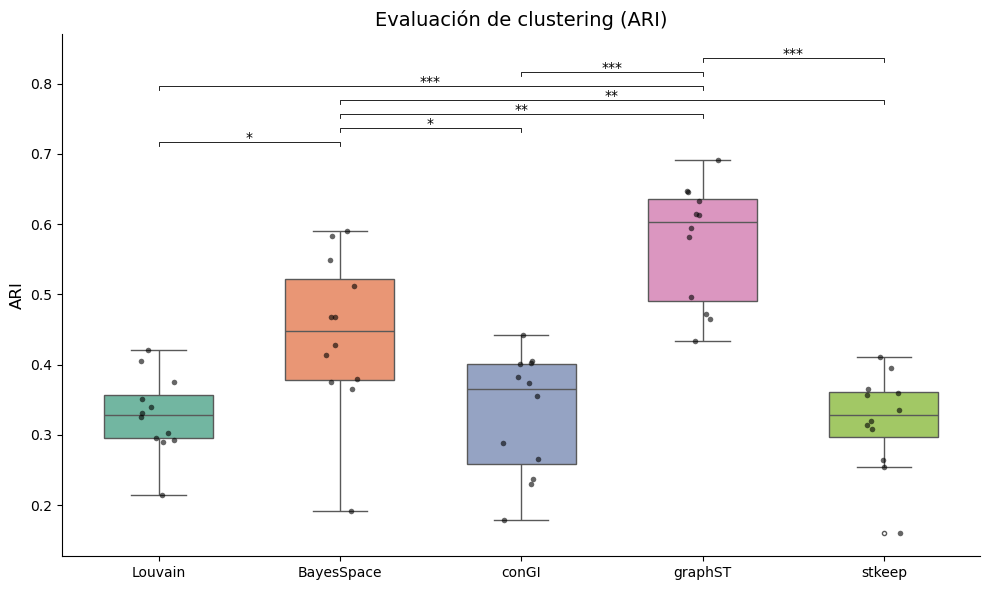

In [ ]:
# Crear un diccionario de significancia
signif_dict = {}
for res in tukey.summary().data[1:]:
    a, b, meandiff, p_adj, lower, upper, reject = res
    if p_adj < 0.001:
        signif = '***'
    elif p_adj < 0.01:
        signif = '**'
    elif p_adj < 0.05:
        signif = '*'
    else:
        signif = ''
    signif_dict[(a, b)] = signif

# Visualización
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_long, x="Método", y="ARI", palette="Set2", width=0.6, fliersize=3)
sns.stripplot(data=df_long, x="Método", y="ARI", color='black', size=4, jitter=True, alpha=0.6)

# Añadir líneas de significancia
y_max = df_long["ARI"].max()
y_offset = 0.02
plotted = 0
for i, (a, b) in enumerate(signif_dict.keys()):
    signif = signif_dict[(a, b)]
    if signif:
        x1, x2 = val_df.columns.get_loc(a), val_df.columns.get_loc(b)
        y = y_max + y_offset * (plotted + 1)
        plt.plot([x1, x1, x2, x2], [y, y + 0.005, y + 0.005, y], lw=0.6, c='k')
        plt.text((x1 + x2) * 0.5, y + 0.001, signif, ha='center', va='bottom', fontsize=10)
        plotted += 1

plt.title("Evaluación de clustering (ARI)", fontsize=14)
plt.ylabel("ARI", fontsize=12)
plt.xlabel("")
sns.despine()
plt.tight_layout()
plt.show()